# Simple Mosaicing

Clipped scenes with overlap

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import copy

import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
import pandas as pd

import up42

In [2]:
# Catalog currently only works with account authentification!
api = up42.Api(auth_type="account", cfg_file="config.json", env="dev")

2020-03-19 03:04:22,814 - up42.api - INFO - Got credentials from config.json.
2020-03-19 03:04:22,815 - up42.api - INFO - Using authentification type - account


### Define aoi

In [3]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              16.136856079101562,
              52.48905227994953
            ],
            [
              16.105613708496094,
              52.48382562716317
            ],
            [
              16.108016967773438,
              52.42880360005013
            ],
            [
              16.163291931152337,
              52.45496332664627
            ],
            [
              16.14131927490234,
              52.47922565896135
            ],
            [
              16.136856079101562,
              52.48905227994953
            ]
          ]
        ]
      }
    }
  ]
}
        

aoi = gpd.GeoDataFrame.from_features(
    aoi, crs={"init": "epsg:4326"}
)
aoi

,geometry
0,"POLYGON ((16.13686 52.48905, 16.10561 52.48383..."


### Search available images

,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,providerProperties,scene_id
0,"POLYGON ((15.83374 52.63821, 16.14682 52.63398...",f2242438-10cf-4a2a-8be3-542732b383f3,2018-08-08T10:20:14Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18031593', 'acquisi...",DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_0...
1,"POLYGON ((15.84263 52.47198, 16.13821 52.47199...",ac1f249c-39e5-4d33-8f95-565cc3ef0025,2018-08-03T10:09:00Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18031831', 'acquisi...",DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_0...


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            2 non-null      geometry
 1   id                  2 non-null      object  
 2   acquisitionDate     2 non-null      object  
 3   constellation       2 non-null      object  
 4   providerName        2 non-null      object  
 5   blockNames          2 non-null      object  
 6   cloudCoverage       2 non-null      float64 
 7   providerProperties  2 non-null      object  
 8   scene_id            2 non-null      object  
dtypes: float64(1), geometry(1), object(7)
memory usage: 160.0+ bytes


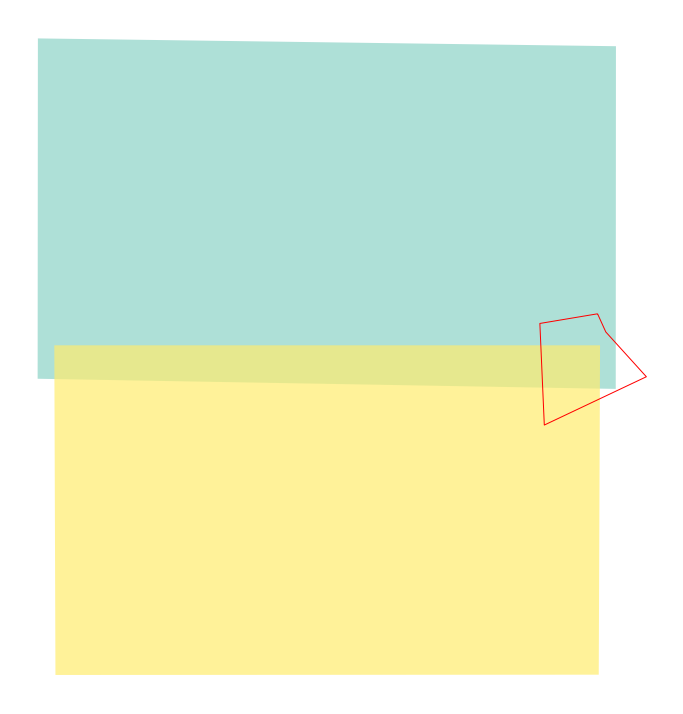

In [4]:
catalog = up42.Catalog(api=api)
search_paramaters = catalog.construct_parameter(geometry=aoi, 
                                                start_date="2018-08-02",
                                                end_date="2020-08-09",
                                                sensors=["pleiades"],
                                                max_cloudcover=20,
                                                sortby="cloudCoverage", 
                                                limit=2)
#print(search_paramaters)

search_results = catalog.search(search_paramaters=search_paramaters, as_dataframe=True)
display(search_results.head())
search_results.info()

# Export
search_results[["geometry", "id", "scene_id", "cloudCoverage"]].to_file(driver="GeoJSON", filename=Path.cwd() / "search_results.geojson")

catalog.plot_coverage(scenes=search_results, aoi=aoi)

### Full scene quicklooks

/Users/christoph.rieke/.virtualenvs/up42-py/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


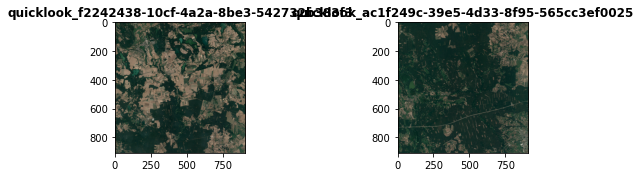

In [5]:
ids=search_results["id"].tolist()
ql_paths = catalog.download_quicklook(image_ids=ids, provider="oneatlas", out_dir=Path.cwd() / "quicklooks")
ql_paths

catalog.plot_quicklook()

### Download images

In [6]:
blocks=api.get_blocks(basic=True)
blocks

2020-03-19 03:04:27,664 - up42.api - INFO - Getting public blocks.


{'tiling': 'd350aa0b-ac31-4021-bbe6-fd8da366740a',
 'oneatlas-spot-aoiclipped': '0f15e07f-efcc-4598-939b-18aade349c57',
 'oneatlas-pleiades-aoiclipped': 'f026874d-e95e-4293-b811-7667130e054d',
 'sobloo-s1-grd-fullscene': '4524e2de-c780-488d-9818-fe68dad9f095',
 'sobloo-s2-l1c-fullscene': '604988cb-8252-4161-bf28-f6fb63d7371c',
 'snap-polarimetric': '320158d6-8f93-4484-a828-e1fb64f677ff',
 'sentinelhub-s2-aoiclipped': 'c4758545-4b74-4318-ae1f-d5ba72f234ca',
 'sentinelhub-landsat8-aoiclipped': 'e0b133ae-7b9c-435c-99ac-c4527cc8d9cf',
 'sobloo-s1-slc-fullscene': 'cf822545-c73c-467b-8f43-5311dbefe03f',
 'nasa-modis': '61279eb8-02e1-4b7a-ac3d-1f62d19d3484',
 's2-superresolution': '4872fef8-aec8-4dec-adcb-560ee4430a2b',
 'oneatlas-pleiades-fullscene': '8487adcd-a4d7-4cb7-b826-75a533e1f330',
 'oneatlas-spot-fullscene': 'aa62113f-0dd1-40a3-a004-954c9d087071',
 'data-conversion': '470eedda-5f62-433c-8562-98eb8783af87',
 'pansharpen': '2f24c662-c129-409f-a7c3-afa16a4c78cb',
 'sobloo-s1-grd-aoicli

In [7]:
ids = search_results.scene_id.to_list()
print(ids)

project = api.create_project("mosaicing", use_existing=True)
workflow = project.create_workflow("mosaicing", use_existing=True)

['DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_01804', 'DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_01804']


2020-03-19 03:04:51,892 - up42.api - INFO - Using existing project: mosaicing, 5558ea8e-5f89-4a71-a5b3-82ff0b05de84.
2020-03-19 03:04:52,924 - up42.project - INFO - Using existing workflow: mosaicing, c5e06156-17a0-4a7c-9351-75445d8d7cc6.


In [8]:
workflow.add_workflow_tasks([blocks["oneatlas-pleiades-aoiclipped"]])

parameters = workflow.construct_parameter(geometry=aoi, geometry_operation="intersects", scene_ids=ids)
parameters

2020-03-19 03:04:53,761 - up42.api - INFO - Getting public blocks.
2020-03-19 03:04:54,460 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'oneatlas-pleiades-aoiclipped:1', 'parentName': None, 'blockId': 'f026874d-e95e-4293-b811-7667130e054d'}]


{'oneatlas-pleiades-aoiclipped:1': {'time': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00',
  'limit': 2,
  'zoom_level': 18,
  'max_cloud_cover': 100,
  'panchromatic_band': False,
  'ids': ['DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_01804',
   'DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_01804'],
  'intersects': {'type': 'Polygon',
   'coordinates': (((16.136856079101562, 52.48905227994953),
     (16.105613708496094, 52.48382562716317),
     (16.108016967773438, 52.42880360005013),
     (16.163291931152337, 52.45496332664627),
     (16.14131927490234, 52.47922565896135),
     (16.136856079101562, 52.48905227994953)),)}}}

In [12]:
#job = workflow.create_and_run_job(parameters, track_status=True)

job = up42.Job(api=api, job_id="a0d94294-d52b-4eb9-9ce9-ff1c3bd033e5", project_id=api.project_id)

2020-03-19 03:06:59,085 - up42.workflow - INFO - Got 11 jobs for workflow c5e06156-17a0-4a7c-9351-75445d8d7cc6 in project 5558ea8e-5f89-4a71-a5b3-82ff0b05de84.


,geometry,acquisitionDate,acquisitionIdentifier,acquisitionStation,archivingCenter,azimuthAngle,cloudCover,commercialReference,constellation,correlationId,...,resolution,sensorType,snowCover,sourceIdentifier,spectralRange,title,workspaceId,workspaceName,workspaceTitle,up42.data_path
0,"POLYGON ((16.10870 52.44848, 16.10733 52.44848...",2018-08-08T10:20:14.805Z,DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_0...,SV1,FR1,180.002636,0,SO18031593,PHR,79f55b5c-0d49-4f0e-8fb9-b83ffca648bb,...,0.5,OPTICAL,0,DS_PHR1B_201808081019378_FR1_PX_E015N52_1214_0...,VISIBLE,DS_PHR1B_201808081019378_FR1_PX_E015N52_1214_0...,0e33eb50-3404-48ad-b835-b0b4b72a5625,public,Public,efd686f3-7710-40b6-a19f-3f6d95e2b7ca.tif
1,"POLYGON ((16.11282 52.43090, 16.11282 52.43006...",2018-08-03T10:09:00.305Z,DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_0...,SV1,FR1,179.982211,0,SO18031831,PHR,48c35677-6efd-47f2-890d-b97395d82d95,...,0.5,OPTICAL,0,DS_PHR1B_201808031008233_FR1_PX_E015N52_1210_0...,VISIBLE,DS_PHR1B_201808031008233_FR1_PX_E015N52_1210_0...,0e33eb50-3404-48ad-b835-b0b4b72a5625,public,Public,3d18abac-55b1-4e98-ba38-2390e38778cc.tif


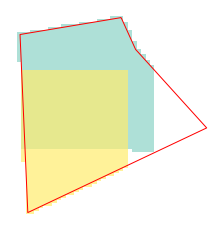

In [16]:
job_result_json = job.get_result_json(as_dataframe=True)
display(job_result_json)

#print("ORDER_IDS:", job_result_json)

catalog.plot_coverage(scenes=job_result_json, aoi=aoi, figsize=(4,4))

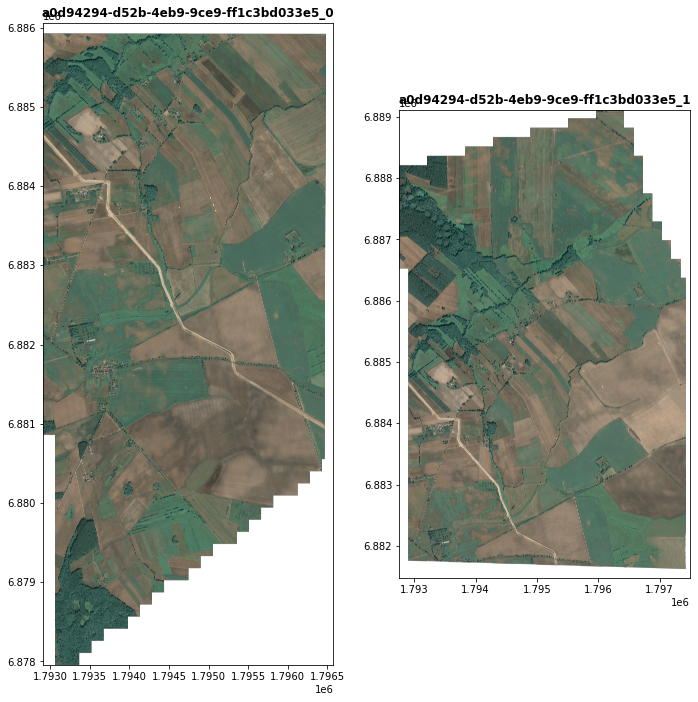

In [44]:
out_filepaths = job.download_result(out_dir=Path.cwd() / "results")
out_filepaths

job.plot_result(figsize=(7,7))

### Mosaic scenes

Sorted by cloudcover

In [ ]:
job_results

In [27]:
#job_results = list(Path("/Users/christoph.rieke/repos/mosaicing/results").glob("*.tif"))
#job_results

[PosixPath('/Users/christoph.rieke/repos/mosaicing/results/a0d94294-d52b-4eb9-9ce9-ff1c3bd033e5_1.tif'),
 PosixPath('/Users/christoph.rieke/repos/mosaicing/results/a0d94294-d52b-4eb9-9ce9-ff1c3bd033e5_0.tif')]

In [28]:
# Sort in order of application, e.g. by cloudcover, date etc.
# Actually is already sorted by download order? results_df

In [29]:
src_files_to_mosaic = []
for fp in job_results:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

    out_profile = src.profile.copy() # bzw. src.meta
print(src_files_to_mosaic)


mosaic, out_transform = merge(src_files_to_mosaic)
print(mosaic.shape)



out_profile.update({
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'blockxsize':256,
    'blockysize':256,
    'tiled' : True  # Important for definition block structure!  
})

out_path = Path.cwd() / "mosaics/mosaic_pleiades.tif"
# Write raster.
with rasterio.open(out_path, 'w', **out_profile) as dst:
        for i in range(mosaic.shape[0]):
            dst.write(mosaic[i,...], i+1)

[<open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/results/a0d94294-d52b-4eb9-9ce9-ff1c3bd033e5_1.tif' mode='r'>, <open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/results/a0d94294-d52b-4eb9-9ce9-ff1c3bd033e5_0.tif' mode='r'>]
(4, 18688, 7936)


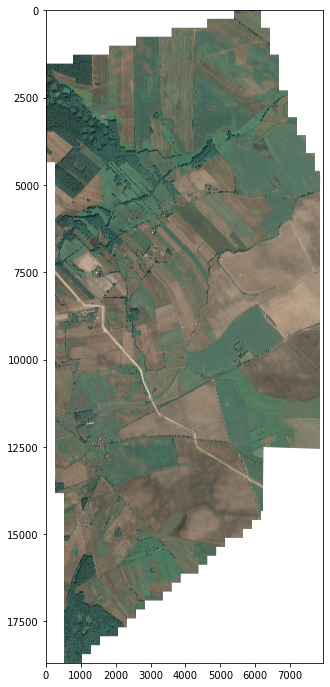

In [45]:
from rasterio.plot import show
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

show(mosaic, ax=ax)
plt.show()